In [1]:
import tsflex
print(tsflex.__version__)

0.1.1.9


## Get the data

In [2]:
import pandas as pd

url = "https://github.com/predict-idlab/tsflex/raw/main/examples/data/empatica/"
df_tmp = pd.read_parquet(url+"tmp.parquet").set_index("timestamp")
df_acc = pd.read_parquet(url+"acc.parquet").set_index("timestamp")
df_gsr = pd.read_parquet(url+"gsr.parquet").set_index("timestamp")
df_ibi = pd.read_parquet(url+"ibi.parquet").set_index("timestamp")

In [3]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_gsr, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Sampling rate: 4.0 Hz

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Sampling rate: 32.0 Hz

Time-series: ['EDA']
(30204, 1)
Sampling rate: 4.0 Hz

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data]
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer='iframe')

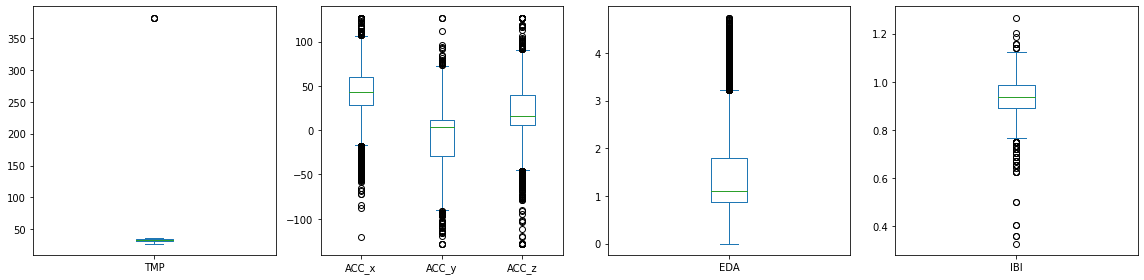

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of notebook containing the example code of the paper.

In [6]:
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Import / create the processing functions
import numpy as np
from scipy.signal import savgol_filter

def clip_quantiles(sig: pd.Series, lower_q=0.01, upper_q=0.99) -> np.ndarray:
    # Note that this function induces a data leakage
    quantile_vals = np.quantile(sig, q=[lower_q, upper_q])
    return np.clip(sig, *quantile_vals)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
clipper_tmp = SeriesProcessor(clip_quantiles, series_names="TMP", lower_q=0, upper_q=0.999)
savgol_eda = SeriesProcessor(savgol_filter, "EDA", window_length=5, polyorder=2)
savgol_acc = SeriesProcessor(savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2)
smv_processor = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline
series_pipe = SeriesPipeline(
    processors=[clipper_tmp, savgol_eda, savgol_acc, smv_processor]
)
series_pipe

[
	clip_quantiles {'lower_q': 0, 'upper_q': 0.999} :  ('TMP',)
	savgol_filter {'window_length': 5, 'polyorder': 2} :  ('EDA',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [7]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

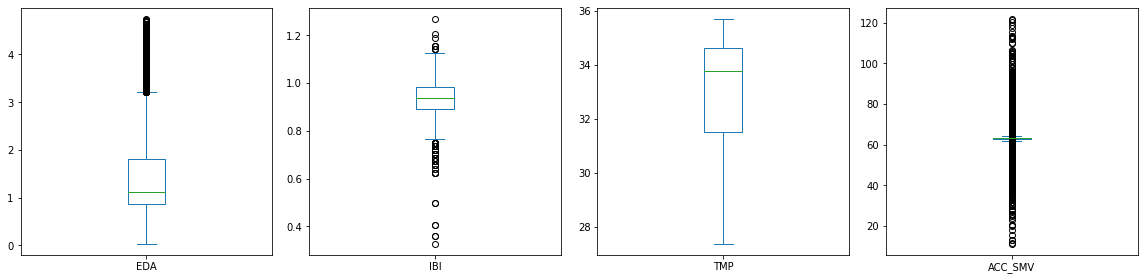

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction with [seglearn](https://github.com/dmbee/seglearn) integration

In [9]:
!pip install seglearn

You should consider upgrading via the '/users/jonvdrdo/.venvs/venv37/bin/python3.7 -m pip install --upgrade pip' command.


As [seglearn feature-functions](https://github.com/dmbee/seglearn/blob/master/seglearn/feature_functions.py) are vectorized along the first axis (axis=0), we need to expand our window-data.  
=> convert `1D np.array` to a `2D np.array` with all the window-data in `axis=1`

In [10]:
# This wrapper does exactly that conversion
from tsflex.features.integrations import seglearn_wrapper

## Using basic seglearn features

In [11]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection

# Import base feature functions from seg-learn
from seglearn.feature_functions import base_features

basic_feats = MultipleFeatureDescriptors(
        functions=[seglearn_wrapper(f, k) for k, f in base_features().items()],
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides="2min",
    )
feature_collection = FeatureCollection(basic_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['min'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['max'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mse, ['mse'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean_crossings, ['mnx'], {}),
	]
	win: 2m30s , stride: 2m: [
		FeatureDescrip

In [12]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__max__w=5m_s=2m,ACC_SMV__min__w=5m_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__mean__w=5m_s=2m,ACC_SMV__std__w=5m_s=2m,ACC_SMV__var__w=5m_s=2m,ACC_SMV__min__w=2m30s_s=2m,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__max__w=2m30s_s=2m,ACC_SMV__mean__w=2m30s_s=2m,...,TMP__max__w=2m30s_s=2m,TMP__median__w=2m30s_s=2m,TMP__mse__w=5m_s=2m,TMP__std__w=2m30s_s=2m,TMP__var__w=2m30s_s=2m,TMP__skew__w=5m_s=2m,TMP__kurt__w=5m_s=2m,TMP__mse__w=2m30s_s=2m,TMP__kurt__w=2m30s_s=2m,TMP__skew__w=2m30s_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,35.954740,1.908184e+07,83.457743,62.975757,...,35.680000,27.610001,NaN,0.752281,0.565926,NaN,NaN,465216.344060,75.956413,7.585334
2017-06-13 14:26:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,44.753951,1.919667e+07,92.325941,63.155303,...,29.510000,29.110001,NaN,0.379786,0.144238,NaN,NaN,504830.393464,-0.952384,-0.493916
2017-06-13 14:27:13+02:00,92.325941,35.954740,3.833208e+07,63.109737,3.175928,10.086518,NaN,NaN,NaN,NaN,...,NaN,NaN,9.787109e+05,NaN,NaN,1.460693,10.492596,NaN,NaN,NaN
2017-06-13 14:28:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,48.631443,1.900028e+07,76.211915,62.903173,...,30.370001,30.059999,NaN,0.361422,0.130626,NaN,NaN,538692.068494,-1.622913,-0.271463
2017-06-13 14:29:13+02:00,92.325941,44.753951,3.821475e+07,63.044016,2.480944,6.155085,NaN,NaN,NaN,NaN,...,NaN,NaN,1.048903e+06,NaN,NaN,-0.312452,-1.085054,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,69.608959,56.499094,3.815810e+07,63.042887,0.629749,0.396584,NaN,NaN,NaN,NaN,...,NaN,NaN,1.109715e+06,NaN,NaN,-0.256389,-1.435013,NaN,NaN,NaN
2017-06-13 16:24:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,40.374098,1.910876e+07,82.316042,63.051531,...,31.049999,30.930000,NaN,0.050810,0.002582,NaN,NaN,574609.351628,-1.067320,0.311723
2017-06-13 16:25:13+02:00,82.316042,40.374098,3.820289e+07,63.055640,1.858570,3.454283,NaN,NaN,NaN,NaN,...,NaN,NaN,1.141975e+06,NaN,NaN,-1.264685,0.349283,NaN,NaN,NaN


### Plot the EDA features

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using all seglearn features

In [14]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection, FuncWrapper

# Import all feature functions from seg-learn
from seglearn.feature_functions import all_features

all_feats = MultipleFeatureDescriptors(
        functions=[seglearn_wrapper(f, k) for k, f in all_features().items()],
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides=["2.5min"],
    )
feature_collection = FeatureCollection(all_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__gmean, ['gmean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__hmean, ['hmean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__vec_sum, ['vec_sum'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_sum, ['abs_sum'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median_absolute_deviation, ['mad'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__variation, ['variation'], {}),
		Feature

In [15]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__mean__w=5m_s=2m30s,ACC_SMV__vec_sum__w=5m_s=2m30s,ACC_SMV__abs_energy__w=5m_s=2m30s,ACC_SMV__abs_sum__w=5m_s=2m30s,ACC_SMV__min__w=5m_s=2m30s,ACC_SMV__hmean__w=5m_s=2m30s,ACC_SMV__max__w=5m_s=2m30s,ACC_SMV__var__w=5m_s=2m30s,ACC_SMV__std__w=5m_s=2m30s,ACC_SMV__median__w=5m_s=2m30s,...,TMP__mse__w=2m30s_s=2m30s,TMP__slope_sign_changes__w=2m30s_s=2m30s,TMP__zero_crossings__w=2m30s_s=2m30s,TMP__waveform_length__w=2m30s_s=2m30s,TMP__mad__w=2m30s_s=2m30s,TMP__emg_var__w=2m30s_s=2m30s,TMP__root_mean_square__w=2m30s_s=2m30s,TMP__kurt__w=2m30s_s=2m30s,TMP__willison_amplitude__w=2m30s_s=2m30s,TMP__skew__w=2m30s_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,465216.344060,598.0,599.0,10.389996,0.326174,776.654968,27.845297,75.956413,599,7.585334
2017-06-13 14:27:13+02:00,63.109737,605853.471250,3.833208e+07,605853.471250,35.954740,62.947225,92.325941,10.086518,3.175928,63.092027,...,513494.515881,598.0,599.0,2.139997,0.340997,857.252930,29.254473,-0.743905,599,-0.226681
2017-06-13 14:29:43+02:00,63.081748,605584.777954,3.826007e+07,605584.777954,44.753951,62.994249,92.325941,6.117127,2.473283,62.937181,...,548563.126964,598.0,599.0,2.160006,0.088955,915.798218,30.236929,1.080655,599,-1.240494
2017-06-13 14:32:13+02:00,62.824989,603119.889884,3.791766e+07,603119.889884,41.660656,62.777776,81.441751,2.776734,1.666353,62.854726,...,571192.662817,598.0,599.0,2.580021,0.385475,953.577087,30.854300,-0.780394,599,0.565035
2017-06-13 14:34:43+02:00,62.684513,601771.324996,3.774950e+07,601771.324996,41.660656,62.635673,81.441751,2.891151,1.700338,62.635014,...,627086.196310,598.0,599.0,2.880007,0.474432,1046.888550,32.328682,-1.275342,599,-0.203421
2017-06-13 14:37:13+02:00,62.852929,603388.122920,3.813345e+07,603388.122920,11.223471,62.389622,121.564172,21.744128,4.663060,62.717138,...,646579.683493,598.0,599.0,2.910019,0.088955,1079.431885,32.827316,0.926125,599,-0.951929
2017-06-13 14:39:43+02:00,62.928250,604111.198743,3.825194e+07,604111.198743,11.223471,62.417887,121.564172,24.612701,4.961119,62.804672,...,639228.471646,598.0,599.0,2.399990,0.311345,1067.159424,32.640171,-1.533498,599,-0.211024
2017-06-13 14:42:13+02:00,62.640208,601345.993076,3.770820e+07,601345.993076,43.888400,62.572703,83.171716,4.142356,2.035278,62.503425,...,657673.813523,598.0,599.0,2.009964,0.296515,1097.953003,33.107750,-1.002241,599,0.583422
2017-06-13 14:44:43+02:00,62.792166,602804.798114,3.786640e+07,602804.798114,45.415474,62.766422,74.364764,1.560255,1.249102,62.692099,...,686044.118809,598.0,599.0,2.509998,0.163087,1145.315674,33.814301,-0.821269,599,0.622996


### Plot the EDA features

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')